#### **Modelo KNN con PCA y Validación Secuencial**

##### **Objetivo**  
Aplicar **K-Nearest Neighbors (KNN)** como modelo no lineal y evaluar su desempeño con:  
- **Validación secuencial**: entrenamiento progresivo, simulando un uso en tiempo real.  
- **PCA (Análisis de Componentes Principales)**: reducción de dimensionalidad, manteniendo el 95% de la varianza.  
- **Undersampling**: balanceo de clases eliminando ejemplos de la clase mayoritaria.  

##### **Ventajas de KNN en este problema**  
- **Modelo no lineal**: puede capturar relaciones más complejas en los datos.  
- **Flexibilidad**: permite probar diferentes métricas de distancia y valores de `k`.  
- **No requiere entrenamiento explícito**: clasifica basándose en los vecinos más cercanos.  

##### **Desafíos de KNN**  
- **Computacionalmente costoso**: puede ser lento con grandes volúmenes de datos.  
- **Sensibilidad al ruido**: necesita un buen preprocesamiento para evitar clasificaciones erróneas.  
- **Manejo de desbalance de clases**: puede sesgarse hacia la clase mayoritaria sin ajustes.  

In [1]:
import mlflow
import mlflow.sklearn
import dagshub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


In [2]:
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

# Configurar el tracking URI con autenticación
mlflow.set_tracking_uri(f"https://dagshub.com/anaigs/tfg_inso_github.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name="tfg_inso_github", mlflow=True)

print(mlflow.get_tracking_uri()) 

Accessing as anaigs

Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

https://dagshub.com/anaigs/tfg_inso_github.mlflow


Codigo con undersamplig

In [3]:
# Parámetros
n_validacion = 38  
n_neighbors = 5  
metric = "euclidean"  

# Cargar datos
file_path = "../../datasets/datasets_equipos/ath_bilbao.csv"
df = pd.read_csv(file_path)

# Preprocesamiento
df = df.drop(columns=["season", "date", "team"])
label_encoder = LabelEncoder()
df["rival_team"] = label_encoder.fit_transform(df["rival_team"])
X = df.drop(columns=["goals_team", "goals_rival", "result"])
y = df["result"]  

# Separar datos en entrenamiento y validación
X_train = X.iloc[: -n_validacion]
y_train = y.iloc[: -n_validacion]
X_val = X.iloc[-n_validacion:]
y_val = y.iloc[-n_validacion:]

In [4]:
# Balanceo con undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Codificar la columna 'rival_team' en valores numéricos
label_encoder = LabelEncoder()
X_train_balanced["rival_team"] = label_encoder.fit_transform(X_train_balanced["rival_team"])
X_val["rival_team"] = label_encoder.transform(X_val["rival_team"])  

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)

# Inicializar listas de resultados
y_pred_seq = []
y_real_seq = []

Accuracy del modelo KNN Básico para Athletic Bilbao: 0.3684

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.32      0.75      0.44         8
  Empate (0)       0.33      0.36      0.35        11
Victoria (1)       0.57      0.21      0.31        19

    accuracy                           0.37        38
   macro avg       0.41      0.44      0.37        38
weighted avg       0.45      0.37      0.35        38



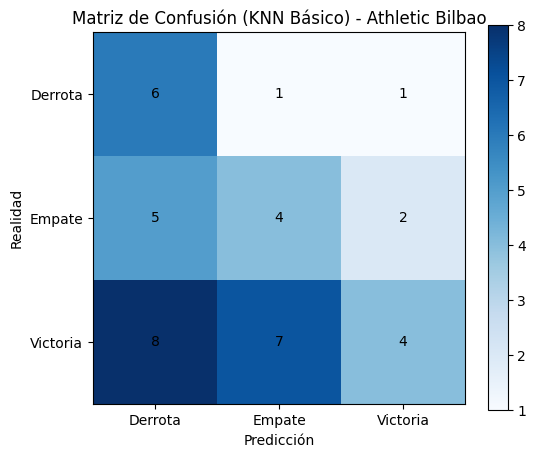

🏃 View run athletic_bilbao_knn_basic at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/b1c58708b2634274ba345a89e3ad0111
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [5]:
with mlflow.start_run(run_name="athletic_bilbao_knn_basic"):
    mlflow.log_param("model_type", "K-Nearest Neighbors")
    mlflow.log_param("approach", "Sequential Validation + Undersampling")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("n_neighbors", n_neighbors)
    mlflow.log_param("metric", metric)

    # Ajustar datos de entrenamiento
    min_samples = min(X_train_scaled.shape[0], y_train_balanced.shape[0])
    X_train_seq = X_train_scaled[:min_samples]
    y_train_seq = np.array(y_train_balanced[:min_samples])

    # Validacion secuencial
    for i in range(n_validacion):
        model_knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        model_knn.fit(X_train_seq, y_train_seq)

        X_next = X_val_scaled[i:i+1]
        y_next = y_val.iloc[i]

        y_pred_next = model_knn.predict(X_next)[0]

        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_next)

        X_train_seq = np.vstack([X_train_seq, X_next])
        y_train_seq = np.append(y_train_seq, y_next)

    # Evaluación del modelo
    accuracy = accuracy_score(y_real_seq, y_pred_seq)
    precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo KNN Básico para Athletic Bilbao: {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (KNN Básico) - Athletic Bilbao")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

#### **Modelo KNN Básico**  

- **Precisión global:** 36.84%, lo que indica que el modelo tiene dificultades para generalizar correctamente.  
- **Predicción de derrotas:** Muy alta en recall (75%), pero con baja precisión (32%), lo que sugiere que el modelo clasifica muchas instancias incorrectamente como derrotas.  
- **Predicción de empates:** Moderada, con 36% de recall y 33% de precisión, lo que indica que sigue confundiendo empates con otras clases.  
- **Predicción de victorias:** Recall del 21%, lo que significa que muchas victorias reales se clasifican como derrotas o empates.  
- **Desbalance en predicciones:** El modelo tiende a favorecer la clase de derrotas y falla en la identificación de victorias.  

Codigo con balanceo de clases y pca

In [6]:
# Parámetros del modelo
n_validacion = 38  # Última temporada como validación
n_neighbors = 5  # Número de vecinos en KNN
metric = "euclidean"  # Distancia euclidiana

# Cargar datos preprocesados
file_path = "../../datasets/datasets_equipos/ath_bilbao.csv"
df = pd.read_csv(file_path)

# Preprocesamiento básico 
df = df.drop(columns=["season", "date", "team"])
X = df.drop(columns=["goals_team", "goals_rival", "result"])
y = df["result"]  # -1 (derrota), 0 (empate), 1 (victoria)

# Separar datos en entrenamiento y validación
X_train = X.iloc[: -n_validacion]
y_train = y.iloc[: -n_validacion]
X_val = X.iloc[-n_validacion:]
y_val = y.iloc[-n_validacion:]

In [7]:
# Aplicar Random Undersampling para balancear clases 
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Codificar la columna 'rival_team' en valores numéricos
label_encoder = LabelEncoder()
X_train_balanced["rival_team"] = label_encoder.fit_transform(X_train_balanced["rival_team"])
X_val["rival_team"] = label_encoder.transform(X_val["rival_team"])  


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(scaler.transform(X_val))

# Obtener el número de componentes retenidos
n_components = pca.n_components_
print(f"Número de componentes principales retenidos: {n_components}")

Número de componentes principales retenidos: 14


Accuracy del modelo KNN con PCA para Athletico de Bilbao: 0.4211

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.35      0.75      0.48         8
  Empate (0)       0.38      0.45      0.42        11
Victoria (1)       0.62      0.26      0.37        19

    accuracy                           0.42        38
   macro avg       0.45      0.49      0.42        38
weighted avg       0.50      0.42      0.41        38



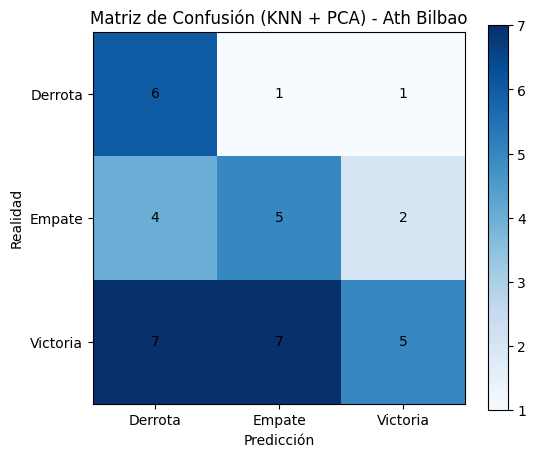

2025/03/29 20:49:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ath_bilbao_knn_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/fd59d365b8dc40a5bba9befbb175c325
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [8]:

# Inicializar listas para almacenar predicciones y resultados reales
y_pred_seq = []
y_real_seq = []

with mlflow.start_run(run_name="ath_bilbao_knn_pca"):
    mlflow.log_param("model_type", "K-Nearest Neighbors")
    mlflow.log_param("approach", "Sequential Validation + Undersampling + PCA")
    mlflow.log_param("team", "Athletico de Bilbao")
    mlflow.log_param("n_neighbors", n_neighbors)
    mlflow.log_param("metric", metric)
    mlflow.log_param("pca_n_components", n_components)

    # Ajustar dimensiones de entrenamiento
    min_samples = min(X_train_pca.shape[0], y_train_balanced.shape[0])
    X_train_pca_seq = X_train_pca[:min_samples]
    y_train_pca_seq = np.array(y_train_balanced[:min_samples])

    # Validacion secuencial
    for i in range(n_validacion):
        # Entrenar el modelo con los datos transformados por PCA
        model_knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        model_knn.fit(X_train_pca_seq, y_train_pca_seq)

        # Obtener el partido a predecir
        X_next_pca = X_val_pca[i:i+1]
        y_next_pca = y_val.iloc[i]

        # Predecir el partido
        y_pred_next_pca = model_knn.predict(X_next_pca)[0]

        # Guardar la predicción y el resultado real
        y_pred_seq.append(y_pred_next_pca)
        y_real_seq.append(y_next_pca)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_pca_seq = np.vstack([X_train_pca_seq, X_next_pca])
        y_train_pca_seq = np.append(y_train_pca_seq, y_next_pca)

    # Evaluación del modelo con PCA
    accuracy_pca = accuracy_score(y_real_seq, y_pred_seq)
    precision_pca = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall_pca = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1_pca = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    # Registrar métricas en MLflow
    mlflow.log_metric("accuracy", accuracy_pca)
    mlflow.log_metric("precision", precision_pca)
    mlflow.log_metric("recall", recall_pca)
    mlflow.log_metric("f1_score", f1_pca)

    # Reporte de clasificación
    report_pca = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo KNN con PCA para Athletico de Bilbao: {accuracy_pca:.4f}")
    print("\nReporte de clasificación:\n", report_pca)

    # Matriz de confusión
    conf_matrix_pca = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix_pca, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (KNN + PCA) - Ath Bilbao")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix_pca[i, j], ha="center", va="center", color="black")

    plt.show()

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(model_knn, "knn_model")

#### **Comparación entre KNN Básico y KNN con PCA**  

- **Precisión global:**  
  - **KNN Básico:** 36.84%  
  - **KNN con PCA:** 42.11% (mejor rendimiento)  

- **Predicción de derrotas:**  
  - **KNN Básico:** 75% de recall, pero con baja precisión (32%).  
  - **KNN con PCA:** 75% de recall, pero la precisión mejora a 35%, lo que indica que PCA ayuda a reducir falsos positivos en derrotas.  

- **Predicción de empates:**  
  - **KNN Básico:** 36% de recall.  
  - **KNN con PCA:** 45% de recall, lo que sugiere que PCA mejora la detección de empates.  

- **Predicción de victorias:**  
  - **KNN Básico:** 21% de recall, el modelo falla en capturar correctamente las victorias.  
  - **KNN con PCA:** 26% de recall, una leve mejora, pero aún con errores significativos.  

- **Impacto del PCA:**  
  - Se observa una mejora en la precisión global y en la predicción de empates y victorias.  
  - Sin embargo, el recall en victorias sigue siendo bajo, lo que sugiere que **PCA ayuda en general pero no resuelve completamente el problema del desbalance de clases**.  

- **Próximo paso:**  
  - Evaluar el impacto de diferentes valores de `k` y métricas de distancia.  

#### **Optimización de hiperparámetros en KNN para Athletic Bilbao**  

**Objetivo**  
Encontrar la mejor combinación de `k` y métrica de distancia para KNN mediante **GridSearchCV** con validación cruzada.  

**Parámetros a optimizar**  
- **Número de vecinos (`k`)**: [3, 5, 7, 9, 11, 15]  
- **Métrica de distancia**: `"euclidean"`, `"manhattan"`, `"minkowski"`  

**Proceso**  
- **Optimización con GridSearchCV**: Validación cruzada (`cv=5`) para estimar el mejor `k` y métrica según la **accuracy**.  


In [9]:
# Parámetros
n_validacion = 38  

# Separar datos en entrenamiento y validación
X_train = X.iloc[: -n_validacion]
y_train = y.iloc[: -n_validacion]
X_val = X.iloc[-n_validacion:]
y_val = y.iloc[-n_validacion:]

# Balanceo con undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Codificar la columna 'rival_team' en valores numéricos
label_encoder = LabelEncoder()      
X_train_balanced["rival_team"] = label_encoder.fit_transform(X_train_balanced["rival_team"])
X_val["rival_team"] = label_encoder.transform(X_val["rival_team"])



In [10]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)

# Definir los parámetros a optimizar
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

# Aplicar GridSearchCV con validación cruzada
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_balanced)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
best_k = best_params["n_neighbors"]
best_metric = best_params["metric"]

# Inicializar listas de resultados
y_pred_seq = []
y_real_seq = []

Accuracy del modelo KNN Optimizado para Athletic Bilbao: 0.4211

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.38      0.75      0.50         8
  Empate (0)       0.22      0.18      0.20        11
Victoria (1)       0.62      0.42      0.50        19

    accuracy                           0.42        38
   macro avg       0.40      0.45      0.40        38
weighted avg       0.45      0.42      0.41        38



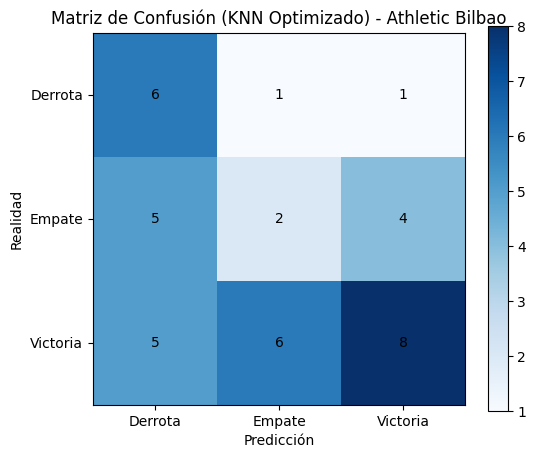

🏃 View run athletic_bilbao_knn_optimized at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/afe2f28f59cf48259b9bdf5c6e828073
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [11]:
with mlflow.start_run(run_name="athletic_bilbao_knn_optimized"):
    mlflow.log_param("model_type", "K-Nearest Neighbors")
    mlflow.log_param("approach", "Sequential Validation + Undersampling + Hyperparameter Tuning")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("n_neighbors", best_k)
    mlflow.log_param("metric", best_metric)

    # Ajustar datos de entrenamiento
    min_samples = min(X_train_scaled.shape[0], y_train_balanced.shape[0])
    X_train_seq = X_train_scaled[:min_samples]
    y_train_seq = np.array(y_train_balanced[:min_samples])

    # Validacion secuencial
    for i in range(n_validacion):
        model_knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
        model_knn.fit(X_train_seq, y_train_seq)

        X_next = X_val_scaled[i:i+1]
        y_next = y_val.iloc[i]

        y_pred_next = model_knn.predict(X_next)[0]

        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_next)

        X_train_seq = np.vstack([X_train_seq, X_next])
        y_train_seq = np.append(y_train_seq, y_next)

    # Evaluación del modelo
    accuracy = accuracy_score(y_real_seq, y_pred_seq)
    precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo KNN Optimizado para Athletic Bilbao: {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (KNN Optimizado) - Athletic Bilbao")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

#### **Conclusión: Modelo KNN Optimizado para Athletic Bilbao**  

- **Precisión global:** 42.11%, mejor que el modelo sin optimización (36.84%).  
- **Predicción de derrotas:** Buen recall (75%), aunque con falsos positivos.  
- **Predicción de empates:** Muy baja (18% recall), sigue siendo la categoría más difícil de identificar.  
- **Predicción de victorias:** Mejora en recall (42%) y precisión (62%), reduciendo falsos negativos.  
- **Impacto de la optimización:** Se logró una mejor precisión general, pero los empates siguen siendo un problema.  

#### Optimización de hiperparámetros en KNN para el resto de los equipos

In [12]:
# Lista de equipos a analizar
equipos = {
    "real_madrid": "../../datasets/datasets_equipos/real_madrid.csv",
    "barcelona": "../../datasets/datasets_equipos/barcelona.csv",
    "valencia": "../../datasets/datasets_equipos/valencia.csv"
}

# Parámetros
n_validacion = 38  
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15],
    "metric": ["euclidean", "manhattan", "minkowski"]
}


Procesando equipo: real_madrid
Accuracy del modelo KNN Optimizado para real_madrid: 0.3947

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.00      0.00      0.00         1
  Empate (0)       0.30      0.38      0.33         8
Victoria (1)       0.86      0.41      0.56        29

    accuracy                           0.39        38
   macro avg       0.39      0.26      0.30        38
weighted avg       0.72      0.39      0.50        38



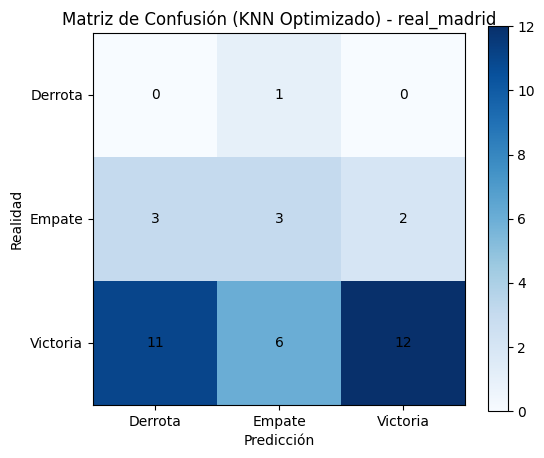

🏃 View run real_madrid_knn_optimized at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/1ff0b5e8ef8e494b8db730d000585bd9
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0

Procesando equipo: barcelona
Accuracy del modelo KNN Optimizado para barcelona: 0.5000

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.20      0.60      0.30         5
  Empate (0)       0.43      0.43      0.43         7
Victoria (1)       0.81      0.50      0.62        26

    accuracy                           0.50        38
   macro avg       0.48      0.51      0.45        38
weighted avg       0.66      0.50      0.54        38



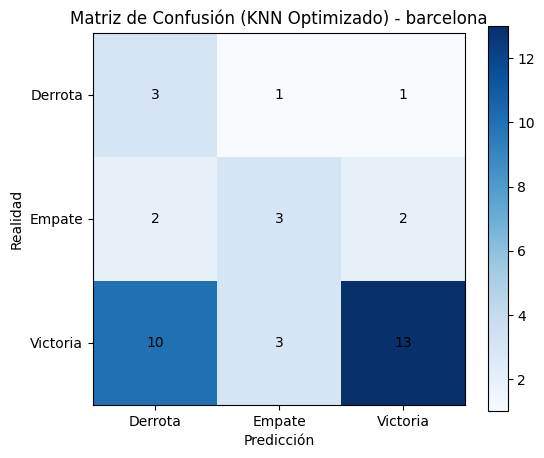

🏃 View run barcelona_knn_optimized at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/0ac7b2837fd14dd08963886bd31310fa
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0

Procesando equipo: valencia
Accuracy del modelo KNN Optimizado para valencia: 0.2895

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.32      0.53      0.40        15
  Empate (0)       0.09      0.10      0.10        10
Victoria (1)       1.00      0.15      0.27        13

    accuracy                           0.29        38
   macro avg       0.47      0.26      0.25        38
weighted avg       0.49      0.29      0.27        38



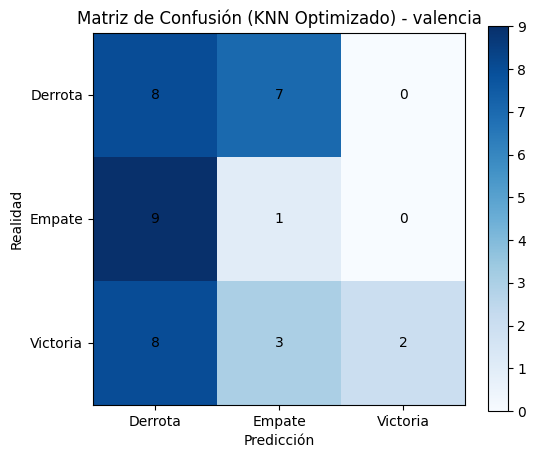

🏃 View run valencia_knn_optimized at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/76ffb9bfdbeb4049a65c1fa7db3cb7f1
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [13]:
for equipo, file_path in equipos.items():
    print(f"\nProcesando equipo: {equipo}")

    # Cargar datos
    df = pd.read_csv(file_path)

    # Preprocesamiento
    df = df.drop(columns=["season", "date", "team"])
    label_encoder = LabelEncoder()
    df["rival_team"] = label_encoder.fit_transform(df["rival_team"])
    X = df.drop(columns=["goals_team", "goals_rival", "result"])
    y = df["result"]

    # Separar datos en entrenamiento y validación
    X_train = X.iloc[: -n_validacion]
    y_train = y.iloc[: -n_validacion]
    X_val = X.iloc[-n_validacion:]
    y_val = y.iloc[-n_validacion:]

    # Balanceo con undersampling
    undersampler = RandomUnderSampler(random_state=42)
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Codificar la columna 'rival_team' en valores numéricos
    label_encoder = LabelEncoder()
    X_train_balanced["rival_team"] = label_encoder.fit_transform(X_train_balanced["rival_team"])
    X_val["rival_team"] = label_encoder.transform(X_val["rival_team"])

    # Escalar los datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_val_scaled = scaler.transform(X_val)

    # Aplicar GridSearchCV con validación cruzada
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_balanced)

    # Obtener los mejores parámetros
    best_params = grid_search.best_params_
    best_k = best_params["n_neighbors"]
    best_metric = best_params["metric"]

    # Inicializar listas de resultados
    y_pred_seq = []
    y_real_seq = []

    with mlflow.start_run(run_name=f"{equipo}_knn_optimized"):
        mlflow.log_param("model_type", "K-Nearest Neighbors")
        mlflow.log_param("approach", "Sequential Validation + Undersampling + Hyperparameter Tuning")
        mlflow.log_param("team", equipo)
        mlflow.log_param("n_neighbors", best_k)
        mlflow.log_param("metric", best_metric)

        # Ajustar datos de entrenamiento
        min_samples = min(X_train_scaled.shape[0], y_train_balanced.shape[0])
        X_train_seq = X_train_scaled[:min_samples]
        y_train_seq = np.array(y_train_balanced[:min_samples])

        # Validacion secuencial
        for i in range(n_validacion):
            model_knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
            model_knn.fit(X_train_seq, y_train_seq)

            X_next = X_val_scaled[i:i+1]
            y_next = y_val.iloc[i]

            y_pred_next = model_knn.predict(X_next)[0]

            y_pred_seq.append(y_pred_next)
            y_real_seq.append(y_next)

            X_train_seq = np.vstack([X_train_seq, X_next])
            y_train_seq = np.append(y_train_seq, y_next)

        # Evaluación del modelo
        accuracy = accuracy_score(y_real_seq, y_pred_seq)
        precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Reporte de clasificación
        report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
        print(f"Accuracy del modelo KNN Optimizado para {equipo}: {accuracy:.4f}")
        print("\nReporte de clasificación:\n", report)

        # Matriz de confusión
        conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

        plt.figure(figsize=(6, 5))
        plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
        plt.colorbar()
        plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.xlabel("Predicción")
        plt.ylabel("Realidad")
        plt.title(f"Matriz de Confusión (KNN Optimizado) - {equipo}")

        for i in range(3):
            for j in range(3):
                plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

        plt.show()

#### **Conclusión breve: Optimización de KNN para múltiples equipos**  

- **Real Madrid:** 39.47% de accuracy, con buen rendimiento en victorias (86% precisión) pero fallos en derrotas (0% recall).  
- **Barcelona:** 50.00% de accuracy, mejor balanceado, con buen desempeño en victorias y empates.  
- **Valencia:** 28.95% de accuracy, el peor rendimiento, con predicción de empates casi nula y victorias sobreestimadas.  

#### **Posibles razones del mal rendimiento en Valencia**  
1. **Distribución de clases desbalanceada**: El modelo podría estar sesgado hacia una clase dominante.  
2. **Falta de información discriminativa**: Las características disponibles podrían no ser suficientes para diferenciar bien los resultados.  
3. **Sensibilidad de KNN a datos ruidosos**: KNN puede verse afectado por la variabilidad de los datos en Valencia más que en otros equipos.  